# Project: Google Play Store
Link to the dataset: https://www.kaggle.com/datasets/lava18/google-play-store-apps

In this project, we are tryting to build a prediction model to estimate the number of installs of an application on Google store. We are treating the data as a big data and



# Download and import all the libraries

In [1]:
! pip install pyspark >& /dev/null

In [2]:
#Pyspark
from pyspark.sql import SparkSession

from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql.functions import when, col,sum, isnan

#Python
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from google.colab import drive
%matplotlib inline

In [3]:
# Create Spark Session and Spark Context
spark = SparkSession.builder.appName('Google_play_project').getOrCreate()  #creating a spark environment
sc = spark.sparkContext

In [4]:
from pyspark.sql import SparkSession

# # Create a SparkSession
# spark = SparkSession.builder.appName("ReadCSV").getOrCreate()
from google.colab import drive
drive.mount('/content/drive')

# Replace 'file_path' with the path to your CSV file
file_path = '/content/drive/MyDrive/BDA IST 718/googleplaystore.csv'

# Read the CSV file into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the first few rows of the DataFrame
df.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------+------------------+------------+----+
|                 App|      Category|Rating|Reviews|Size|   Installs|Type|Price|Content Rating|              Genres|Last Updated|       Current Ver| Android Ver|_c13|
+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------+------------------+------------+----+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M|    10,000+|Free|    0|      Everyone|        Art & Design|    7-Jan-18|             1.0.0|4.0.3 and up|NULL|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967| 14M|   500,000+|Free|    0|      Everyone|Art & Design;Pret...|   15-Jan-18|             2.0.0|4.0.3 and up|NULL|
|U Launcher Lite –...|ART_AND_DESIGN

In [5]:
# # mount the google drive and upload the csv file

# drive.mount('/content/drive')

# df = spark.read\
#     .option("header", "true")\
#     .option("inferSchema", "true")\
#     .csv("/content/drive/My Drive/googleplaystore.csv") #specify the path here to where you store the csv

# Data Cleaning

In [6]:
df.show()

+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------+------------------+------------+----+
|                 App|      Category|Rating|Reviews|Size|   Installs|Type|Price|Content Rating|              Genres|Last Updated|       Current Ver| Android Ver|_c13|
+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------+------------------+------------+----+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M|    10,000+|Free|    0|      Everyone|        Art & Design|    7-Jan-18|             1.0.0|4.0.3 and up|NULL|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967| 14M|   500,000+|Free|    0|      Everyone|Art & Design;Pret...|   15-Jan-18|             2.0.0|4.0.3 and up|NULL|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510|8.7M| 5,000,000+|Free|    0|      Everyone|        Art & Design|    1-Aug-18|             1.2.4|4.0.3 and up|NULL

In [7]:
#checking the dataframe type
type(df)

pyspark.sql.dataframe.DataFrame

In [8]:
#shape of the dataframe
row_count = df.count()
print('Number of rows: ', row_count)
column_count = len(df.columns)
print('Number of cols: ', column_count)

Number of rows:  10841
Number of cols:  14


In [9]:
#checking the dtype of variables
df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)
 |-- _c13: string (nullable = true)



### Cleaning and transforming the columns

In [10]:
# Replace 'M' with '' and 'k' with '' and convert to float type
df = df.withColumn('Size', when(col('Size').contains('M'),
    regexp_replace('Size', 'M', '').cast('float')
).otherwise(
    when(col('Size').contains('k'),
        regexp_replace('Size', 'k', '').cast('float') *0.001 #converting kb to Mb
    ).otherwise(
        col('Size').cast('float')
    )
).cast('float'))

# Filter out rows where 'Size' is 'Varies with Size'
df = df.filter(col('Size').isNotNull())

df.show()

+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------+------------------+------------+----+
|                 App|      Category|Rating|Reviews|Size|   Installs|Type|Price|Content Rating|              Genres|Last Updated|       Current Ver| Android Ver|_c13|
+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------+------------------+------------+----+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159|19.0|    10,000+|Free|    0|      Everyone|        Art & Design|    7-Jan-18|             1.0.0|4.0.3 and up|NULL|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967|14.0|   500,000+|Free|    0|      Everyone|Art & Design;Pret...|   15-Jan-18|             2.0.0|4.0.3 and up|NULL|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510| 8.7| 5,000,000+|Free|    0|      Everyone|        Art & Design|    1-Aug-18|             1.2.4|4.0.3 and up|NULL

In [11]:
columns_to_drop = ["_c13"]
df = df.drop(*columns_to_drop)

In [12]:
# Remove '$' from 'Price' column and convert to DoubleType
df = df.withColumn('Price', F.regexp_replace(F.regexp_replace('Price', '\$', ''), ',', '').cast(DoubleType()))

# Remove '+' and ',' from 'Installs' column and convert to IntegerType
df = df.withColumn('Installs', F.regexp_replace(F.regexp_replace('Installs', '\+', ''), ',', '').cast(IntegerType()))

# Remove '+' and ',' from 'Reviews' column and convert to IntegerType
df = df.withColumn('Reviews', F.regexp_replace(F.regexp_replace('Reviews', '\+', ''), ',', '').cast(IntegerType()))

#Rating- converting to float and removing null
df = df.withColumn('Rating', col('Rating').cast('float'))
df = df.filter(col('Rating').isNotNull())

#casting 'Last update' as date
df = df.withColumn('Last Updated', col('Last Updated').cast('date'))

#removing null values and other unrequired values from some columns
df = df.filter(col('Android Ver').isNotNull())
df = df.filter((col('Type') != '0') & col('Type').isNotNull())
df = df.filter(col('Content Rating')!= 'Unrated')

In [13]:
#checking the dtype again after data conversion
df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: float (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Size: float (nullable = true)
 |-- Installs: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: date (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



In [14]:
df.show()

+--------------------+--------------+------+-------+----+--------+----+-----+--------------+--------------------+------------+------------------+------------+
|                 App|      Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|              Genres|Last Updated|       Current Ver| Android Ver|
+--------------------+--------------+------+-------+----+--------+----+-----+--------------+--------------------+------------+------------------+------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159|19.0|   10000|Free|  0.0|      Everyone|        Art & Design|        NULL|             1.0.0|4.0.3 and up|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967|14.0|  500000|Free|  0.0|      Everyone|Art & Design;Pret...|        NULL|             2.0.0|4.0.3 and up|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510| 8.7| 5000000|Free|  0.0|      Everyone|        Art & Design|        NULL|             1.2.4|4.0.3 and up|
|Sketch - Draw & P...|ART_AND_DESIGN|   4.5| 2

In [15]:
#checking the data shape again after removing nulls
row_count = df.count()
print('Number of rows: ', row_count)
column_count = len(df.columns)
print('Number of cols: ', column_count)

Number of rows:  9141
Number of cols:  13


In [16]:
#checking for null values. NOTE:Ignore the exsitence for null values in last update for now
column_names = df.columns

null_check_result = df.agg(*(sum(col(column).isNull().cast('int')).alias(column) for column in column_names))
null_check_result.show()

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|     0|      0|   0|       0|   0|    0|             0|     0|        9141|          1|          0|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+



In [17]:
df = df.dropna(subset=['Rating'])

In [18]:
#doing unique counts to see and inconsistency in data or existence of nulls
unique_values = df.select('Rating').distinct()
unique_values.show(100)

+------+
|Rating|
+------+
|   5.0|
|   2.5|
|   3.8|
|   2.2|
|   4.6|
|   3.4|
|   4.2|
|   1.8|
|   3.2|
|   2.9|
|   2.0|
|   3.6|
|   3.0|
|   1.5|
|   2.6|
|   3.3|
|   2.8|
|   4.4|
|   3.5|
|   1.0|
|   1.4|
|   1.6|
|   4.1|
|   4.8|
|   2.4|
|   2.7|
|   4.5|
|   3.7|
|   3.9|
|   1.2|
|   1.7|
|   4.0|
|   2.3|
|   3.1|
|   4.7|
|   4.3|
|   2.1|
|   4.9|
|   1.9|
+------+



# EDA

In [19]:
df.count()

7726

In [20]:
# Use the describe method to get summary statistics
summary_stats = df.describe()

# Show the summary statistics
summary_stats.show()

+-------+--------------------+--------------+-----------------+-----------------+-----------------+--------------------+----+------------------+---------------+------+-------------+------------------+
|summary|                 App|      Category|           Rating|          Reviews|             Size|            Installs|Type|             Price| Content Rating|Genres|  Current Ver|       Android Ver|
+-------+--------------------+--------------+-----------------+-----------------+-----------------+--------------------+----+------------------+---------------+------+-------------+------------------+
|  count|                7726|          7726|             7726|             7726|             7726|                7726|7726|              7726|           7726|  7726|         7725|              7726|
|   mean|                NULL|          NULL|4.173789795973188|294786.4104323065|22.96463156907949|   8420864.913020968|NULL| 1.128052032099394|           NULL|  NULL|          NaN|               

In [21]:
# Find value counts of string columns
string_cols = [col_name for col_name, col_type in df.dtypes if col_type == "string"]

for col_name in string_cols:
    col_counts = df.groupBy(col_name).count().orderBy(col_name)
    col_counts.show()

+--------------------+-----+
|                 App|count|
+--------------------+-----+
|"Alphabet ""H"" P...|    1|
|"Eat Fast Prepare...|    1|
|              #NAME?|    1|
|+Download 4 Insta...|    1|
|                  .R|    1|
|              /u/app|    1|
|              058.ba|    1|
|      1. FC Köln App|    1|
|10 Best Foods for...|    2|
|10 Minutes a Day ...|    1|
|10 WPM Amateur ha...|    1|
|10,000 Quotes DB ...|    1|
|100 Doors of Revenge|    1|
|     100+ C Programs|    1|
|100000+ Messages ...|    1|
|101 C Programming...|    1|
|104 Looking for a...|    1|
|                11st|    1|
|12 Step Meditatio...|    1|
|17th Edition Cabl...|    1|
+--------------------+-----+
only showing top 20 rows

+-------------------+-----+
|           Category|count|
+-------------------+-----+
|     ART_AND_DESIGN|   59|
|  AUTO_AND_VEHICLES|   63|
|             BEAUTY|   37|
|BOOKS_AND_REFERENCE|  144|
|           BUSINESS|  246|
|             COMICS|   49|
|      COMMUNICATION|  211

In [22]:
from pyspark.sql.functions import col, countDistinct
for col_name in string_cols:
    col_nunique = df.agg(countDistinct(col(col_name)).alias('nunique')).first()['nunique']
    print(f"Column '{col_name}' has {col_nunique} unique values.")

Column 'App' has 7026 unique values.
Column 'Category' has 33 unique values.
Column 'Type' has 2 unique values.
Column 'Content Rating' has 5 unique values.
Column 'Genres' has 112 unique values.
Column 'Current Ver' has 2476 unique values.
Column 'Android Ver' has 32 unique values.


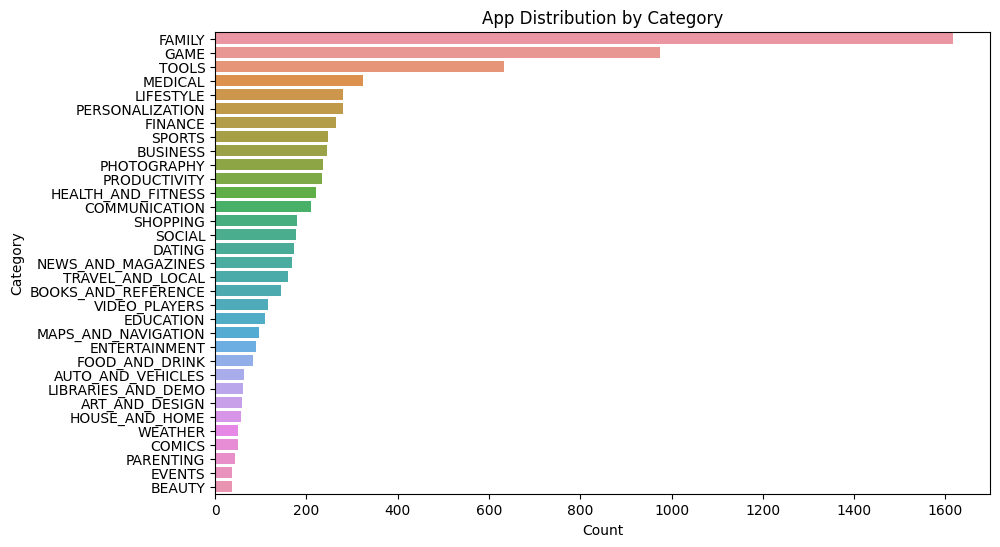

In [23]:
# Family category has the highest app distribution
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for plotting
df_panda = df.toPandas()

# Plotting the count plot using Matplotlib or Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(y='Category', data=df_panda, order=df_panda['Category'].value_counts().index)
plt.title('App Distribution by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()


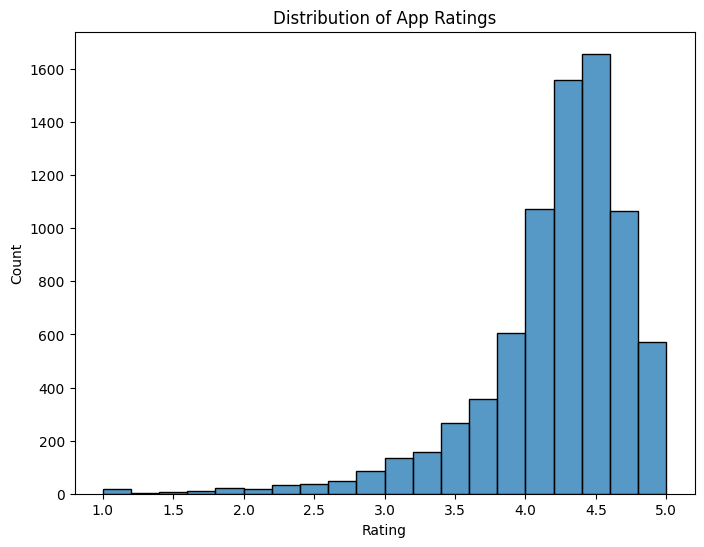

In [24]:
#
# Rating Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df_panda['Rating'], bins=20)
plt.title('Distribution of App Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

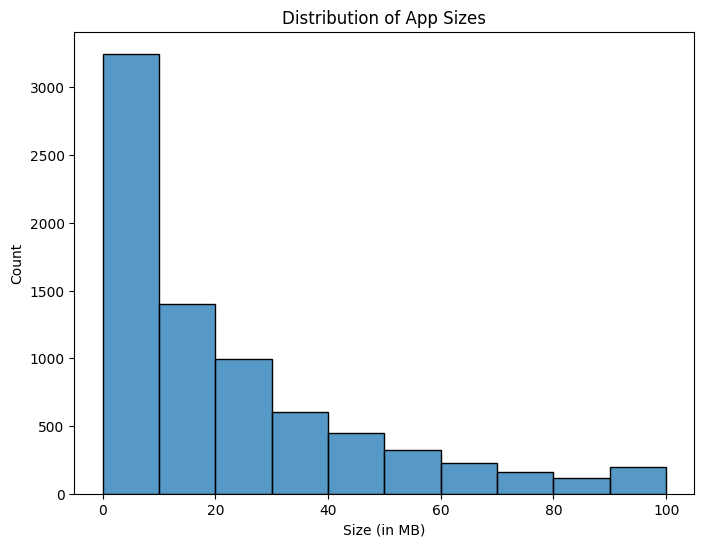

In [25]:
#App sizes ranging from 0-10 have the highest distribution
plt.figure(figsize=(8, 6))
sns.histplot(df_panda['Size'], bins=10)
plt.title('Distribution of App Sizes')
plt.xlabel('Size (in MB)')
plt.ylabel('Count')
plt.show()


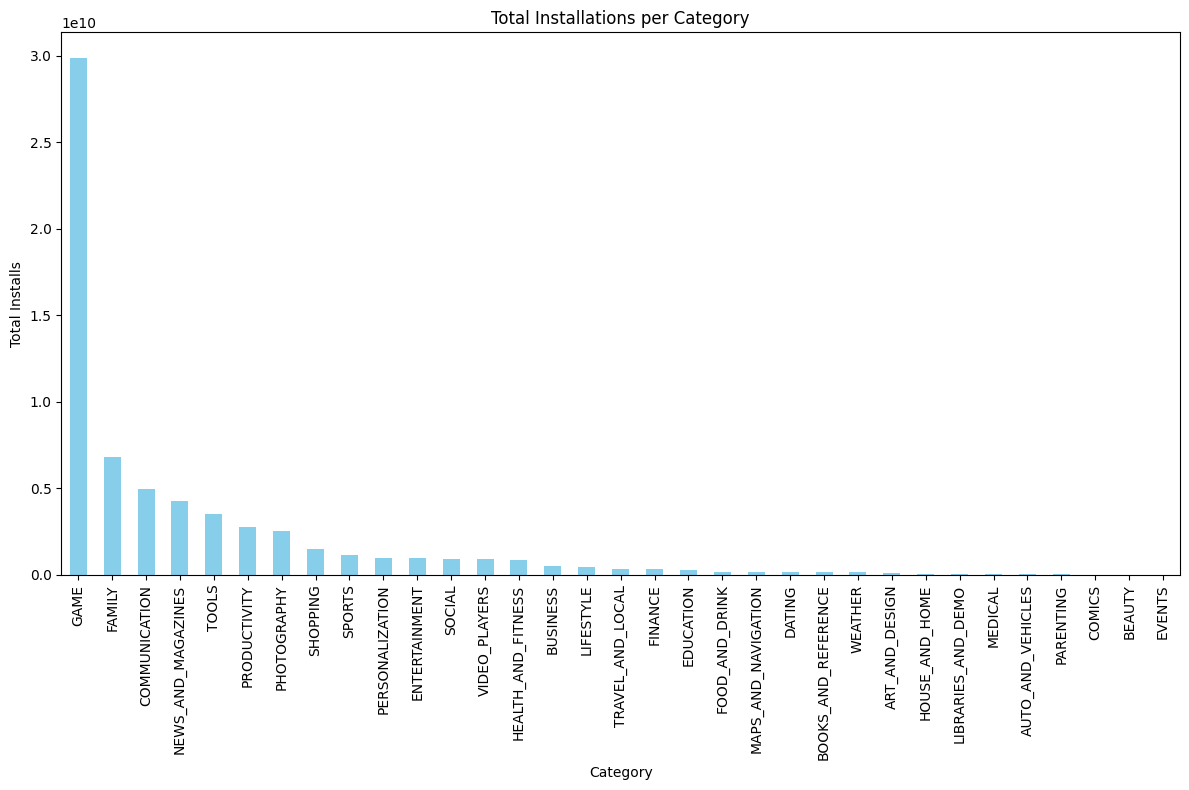

In [26]:
import matplotlib.pyplot as plt

# Assuming you have a Pandas DataFrame df_panda with the relevant data

# Grouping by category and summing the installations
installations_per_category = df_panda.groupby('Category')['Installs'].sum().sort_values(ascending=False)

# Plotting the installations across categories using a bar plot
plt.figure(figsize=(12, 8))
installations_per_category.plot(kind='bar', color='skyblue')
plt.title('Total Installations per Category')
plt.xlabel('Category')
plt.ylabel('Total Installs')
plt.xticks(rotation=90)
plt.tight_layout()



# Show the plot
plt.show()


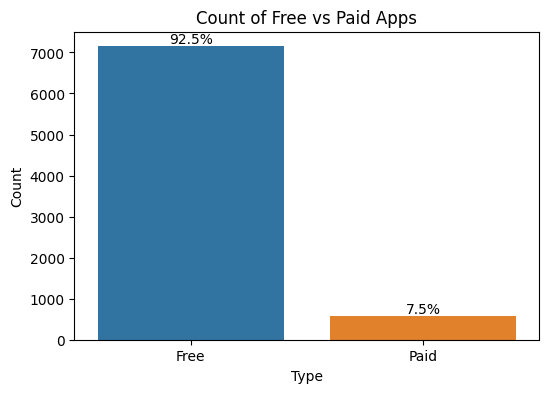

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a Pandas DataFrame df_panda with the relevant data

# Count of Free vs Paid apps
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Type', data=df_panda)
plt.title('Count of Free vs Paid Apps')
plt.xlabel('Type')
plt.ylabel('Count')

# Calculate proportions of free and paid apps
total_apps = len(df_panda)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_apps)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()



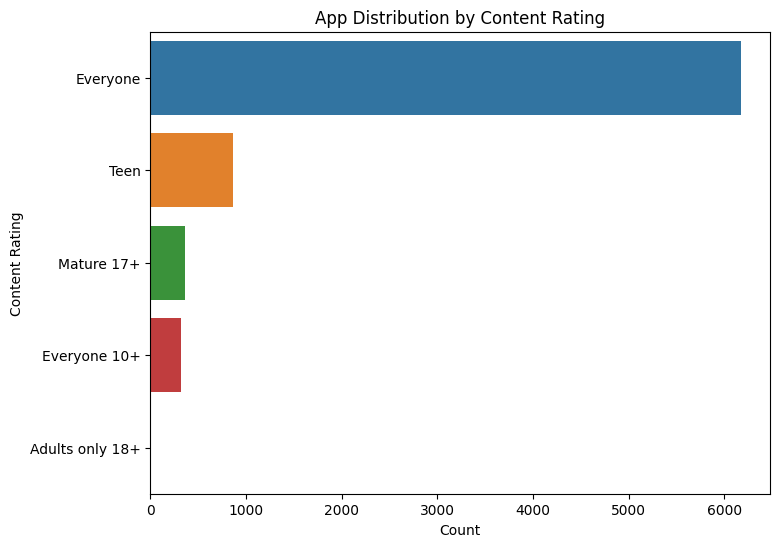

In [28]:
# Content Rating Distribution
plt.figure(figsize=(8, 6))
sns.countplot(y='Content Rating', data=df_panda, order=df_panda['Content Rating'].value_counts().index)
plt.title('App Distribution by Content Rating')
plt.xlabel('Count')
plt.ylabel('Content Rating')
plt.show()

<ipython-input-29-55ab811bff4e>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_panda.corr()


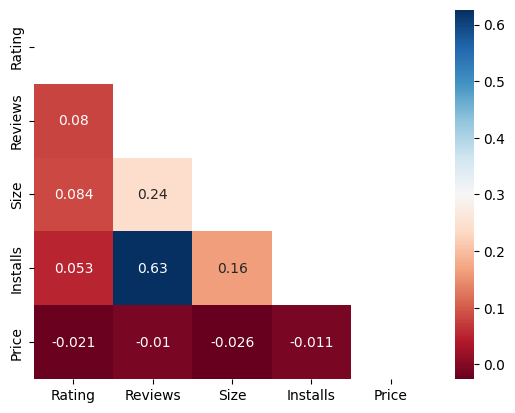

In [29]:
#correlation

# Calculate the correlation matrix
correlation_matrix = df_panda.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create the correlation heatmap with mask
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu')

# Show the plot
plt.show()

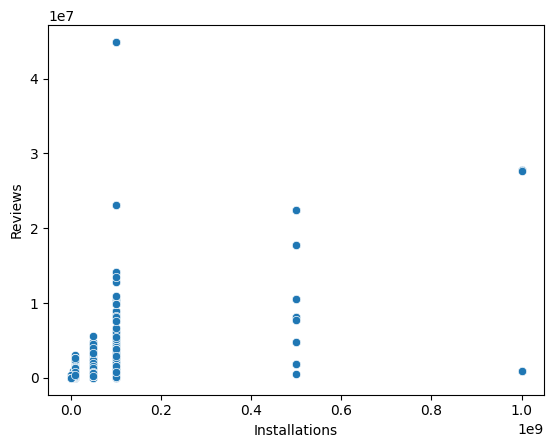

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a Pandas DataFrame named 'data' with 'installations' and 'reviews' columns

# Create the scatter plot
sns.scatterplot(data=df_panda, x='Installs', y='Reviews')

# Set the axis labels
plt.xlabel('Installations')
plt.ylabel('Reviews')

# Display the plot
plt.show()

# Supervised Model:

In [31]:
# checking the schema
df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: float (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Size: float (nullable = true)
 |-- Installs: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: date (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



### Building a multivariate linear regression model using reasonable numeric inputs: Rating, Reviews, Size, Price

In [32]:
from pyspark.ml import feature, evaluation, Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.sql import functions as fn
from pyspark.ml.evaluation import RegressionEvaluator


Let's first create the training, testing and validation sets:

In [33]:
training_df, validation_df, testing_df = df.randomSplit([0.6, 0.2, 0.2], seed = 1989)

In [34]:
[training_df.count(), validation_df.count(), testing_df.count()]

[4617, 1480, 1629]

In [35]:
training_df.show()

+--------------------+-------------------+------+-------+-----+--------+----+-----+--------------+-----------------+------------+-----------+------------+
|                 App|           Category|Rating|Reviews| Size|Installs|Type|Price|Content Rating|           Genres|Last Updated|Current Ver| Android Ver|
+--------------------+-------------------+------+-------+-----+--------+----+-----+--------------+-----------------+------------+-----------+------------+
|"Alphabet ""H"" P...|    PERSONALIZATION|   4.5|      2|  3.0|     100|Free|  0.0|      Everyone|  Personalization|        NULL|          1|  4.1 and up|
|"Eat Fast Prepare...|     FOOD_AND_DRINK|   4.6|   4925| 17.0| 1000000|Free|  0.0|      Everyone|     Food & Drink|        NULL|      3.6.6|4.0.3 and up|
|+Download 4 Insta...|             SOCIAL|   4.5|  40467| 22.0| 1000000|Free|  0.0|      Everyone|           Social|        NULL|       5.03|  4.1 and up|
|                  .R|              TOOLS|   4.5|    259|0.203|   1000

In [36]:
lr_model = Pipeline(stages = [
  feature.VectorAssembler(inputCols = ['Rating', 'Reviews', 'Size', 'Price'], outputCol = 'features'),
  LinearRegression(featuresCol = 'features', labelCol = 'Installs')
]).fit(training_df)

Then, we'll evaluate the model on validation dataset and compute the RMSE

In [37]:
import math

evaluator = RegressionEvaluator(
    labelCol = 'Installs',
    predictionCol = 'prediction',
    metricName = 'mse')

validation_lr = lr_model.transform(validation_df)

lr_mse = evaluator.evaluate(validation_lr)

lr_rmse = math.sqrt(lr_mse)

print(lr_rmse)

44019633.093637645


Fit the pipeline in training dataset

In [38]:
predictions_lr = lr_model.transform(testing_df)

# Show the predictions on the testing data
predictions_lr.select('Rating', 'Reviews', 'Size', 'Price', 'Installs', 'prediction').show()

+------+-------+-----+-----+--------+------------------+
|Rating|Reviews| Size|Price|Installs|        prediction|
+------+-------+-----+-----+--------+------------------+
|   3.5|    115|  9.1|  0.0|   10000| 3464161.463210894|
|   3.5|     10|  3.8| 1.49|     100| 3466787.653278189|
|   3.7|    121|  3.8|  0.0|   10000| 3354260.119860238|
|   4.2|     33| 13.0|  0.0|    1000|2990685.1858909684|
|   3.0|      4|  2.0|  0.0|    1000|3815463.1872808947|
|   4.4|  11506| 15.0|  0.0|  100000|3092695.3380018864|
|   4.0|    337| 32.0|  0.0|   10000|3054190.0361457574|
|   3.5|    224|0.371|  0.0|   10000| 3500140.809015437|
|   4.1|  62209|  7.4|  0.0|10000000| 4379367.537578394|
|   4.4|   1518| 37.0|  0.0|  100000|2798641.7743088296|
|   4.3|   6333| 30.0|  0.0| 1000000| 2991722.625426729|
|   4.4|    467|  7.3|  0.0|  100000| 2891289.156309355|
|   4.3|    488|  2.5|  0.0|   50000| 2975501.985112235|
|   4.2|    268|  2.4|  0.0|   10000|3036525.4223517464|
|   4.2|   2058|  2.3|  0.0|  1

In [39]:
# Access the Linear Regression model from the pipeline stages
lr_model = lr_model.stages[-1]

# View the coefficients
coefficients = lr_model.coefficients
print("Coefficients: ", coefficients)

# View the intercept
intercept = lr_model.intercept
print("Intercept: ", intercept)

Coefficients:  [-652434.4073735948,20.93767566452893,-3860.366325261007,-10493.488032552037]
Intercept:  5780403.391349543


We can see it's generally not performing very well, but the linear regression model establish a baseline here.

# Building decision tree regressor to predict downloads


In [40]:
from pyspark.ml.regression import DecisionTreeRegressor

dt_model_1 = Pipeline(stages = [
  feature.VectorAssembler(inputCols = ['Rating', 'Reviews', 'Size', 'Price'], outputCol = 'features'),
  DecisionTreeRegressor(featuresCol = 'features', labelCol = 'Installs')
]).fit(training_df)

Evaluate our decision tree model on validation dataset:

In [41]:
validation_dt_1 = dt_model_1.transform(validation_df)

dt_1_mse = evaluator.evaluate(validation_dt_1)

dt_1_rmse = math.sqrt(dt_1_mse)

print(dt_1_rmse)

37400491.78732251


The RMSE is smaller than the one from linear model, indicating potential improvement in accuracy

In [42]:
# Make predictions with Decision Tree Model 1 on testing set
predictions_dt = dt_model_1.transform(testing_df)

# Show the predictions on the testing data
predictions_dt.select('Rating', 'Reviews', 'Size', 'Price', 'Installs', 'prediction').show()

+------+-------+-----+-----+--------+------------------+
|Rating|Reviews| Size|Price|Installs|        prediction|
+------+-------+-----+-----+--------+------------------+
|   3.5|    115|  9.1|  0.0|   10000|34708.725508317926|
|   3.5|     10|  3.8| 1.49|     100|34708.725508317926|
|   3.7|    121|  3.8|  0.0|   10000|34708.725508317926|
|   4.2|     33| 13.0|  0.0|    1000|34708.725508317926|
|   3.0|      4|  2.0|  0.0|    1000|34708.725508317926|
|   4.4|  11506| 15.0|  0.0|  100000|  850534.188034188|
|   4.0|    337| 32.0|  0.0|   10000|34708.725508317926|
|   3.5|    224|0.371|  0.0|   10000|34708.725508317926|
|   4.1|  62209|  7.4|  0.0|10000000|3483879.0931989923|
|   4.4|   1518| 37.0|  0.0|  100000|34708.725508317926|
|   4.3|   6333| 30.0|  0.0| 1000000|  850534.188034188|
|   4.4|    467|  7.3|  0.0|  100000|34708.725508317926|
|   4.3|    488|  2.5|  0.0|   50000|34708.725508317926|
|   4.2|    268|  2.4|  0.0|   10000|34708.725508317926|
|   4.2|   2058|  2.3|  0.0|  1

Next, we'll include categorical variables into decision tree models:


In [43]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
# Categorical variables
categorical_cols = ['Category', 'Type', 'Content Rating', 'Genres']

# StringIndexer for each categorical variable
indexers = [StringIndexer(inputCol=col, outputCol=col + 'Index', handleInvalid='keep') for col in categorical_cols]

# OneHotEncoder for each indexed categorical variable
encoders = [OneHotEncoder(inputCol=col + 'Index', outputCol=col + 'OneHot') for col in categorical_cols]

# Combine all input features (including one-hot encoded categorical features)
feature_columns = ['Rating', 'Reviews', 'Size', 'Price'] + [col + 'OneHot' for col in categorical_cols]

# VectorAssembler to assemble all features
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# DecisionTreeRegressor
dt_model_2 = DecisionTreeRegressor(featuresCol='features', labelCol='Installs')

# Create a Pipeline
dt_pipeline_2 = Pipeline(stages=indexers + encoders + [vector_assembler, dt_model_2])

# Train the model
dt_model_2 = dt_pipeline_2.fit(training_df)

In [44]:
# Evaluate Model 2 on validation dataset
dt_predictions_2 = dt_model_2.transform(validation_df)
dt_2_mse = evaluator.evaluate(dt_predictions_2)
dt_2_rmse = math.sqrt(dt_2_mse)

print(dt_2_rmse)

33449809.81180949


In [45]:
print(dt_1_rmse - dt_2_rmse)

3950681.975513015


The decision tree model that includes categorical variables improve compared with the one with only numeric variables.

In [46]:
predictions_dt_2 = dt_model_2.transform(testing_df)

# Show the predictions on the testing data
predictions_dt_2.select('Rating', 'Reviews', 'Size', 'Price','Category', 'Type', 'Content Rating', 'Genres', 'prediction', 'Installs').show()

+------+-------+-----+-----+------------------+----+--------------+--------------------+------------------+--------+
|Rating|Reviews| Size|Price|          Category|Type|Content Rating|              Genres|        prediction|Installs|
+------+-------+-----+-----+------------------+----+--------------+--------------------+------------------+--------+
|   3.5|    115|  9.1|  0.0|            COMICS|Free|    Mature 17+|              Comics|34708.725508317926|   10000|
|   3.5|     10|  3.8| 1.49|     COMMUNICATION|Paid|      Everyone|       Communication|34708.725508317926|     100|
|   3.7|    121|  3.8|  0.0|         LIFESTYLE|Free|    Mature 17+|           Lifestyle|34708.725508317926|   10000|
|   4.2|     33| 13.0|  0.0|              GAME|Free|          Teen|              Action|34708.725508317926|    1000|
|   3.0|      4|  2.0|  0.0|             TOOLS|Free|      Everyone|               Tools|34708.725508317926|    1000|
|   4.4|  11506| 15.0|  0.0|HEALTH_AND_FITNESS|Free|      Everyo

# Buidling random forest model:

In [47]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features', labelCol='Installs', numTrees=100)

# Create a Pipeline
rf_pipeline = Pipeline(stages=indexers + encoders + [vector_assembler, rf])

# Train the model
rf_model = rf_pipeline.fit(training_df)

In [48]:
# Evaluate the model on validation set
rf_predictions = rf_model.transform(validation_df)
rf_evaluator = RegressionEvaluator(labelCol='Installs', predictionCol='prediction', metricName='mse')
rf_mse = rf_evaluator.evaluate(rf_predictions)
rf_rmse = math.sqrt(rf_mse)

print(dt_1_rmse)
print(rf_rmse)

37400491.78732251
31498354.208011024


In [49]:
print(dt_2_rmse - rf_rmse)

1951455.6037984677


Random forest model preform better than the decision tree model

In [50]:
predictions_rf = rf_model.transform(testing_df)

# Show the predictions on the testing data
predictions_rf.select('Rating', 'Reviews', 'Size', 'Price','Category', 'Type', 'Content Rating', 'Genres', 'prediction', 'Installs').show()

+------+-------+-----+-----+------------------+----+--------------+--------------------+------------------+--------+
|Rating|Reviews| Size|Price|          Category|Type|Content Rating|              Genres|        prediction|Installs|
+------+-------+-----+-----+------------------+----+--------------+--------------------+------------------+--------+
|   3.5|    115|  9.1|  0.0|            COMICS|Free|    Mature 17+|              Comics| 1122892.979193605|   10000|
|   3.5|     10|  3.8| 1.49|     COMMUNICATION|Paid|      Everyone|       Communication| 794748.4132635493|     100|
|   3.7|    121|  3.8|  0.0|         LIFESTYLE|Free|    Mature 17+|           Lifestyle|1082629.5937033175|   10000|
|   4.2|     33| 13.0|  0.0|              GAME|Free|          Teen|              Action|3273390.9591343445|    1000|
|   3.0|      4|  2.0|  0.0|             TOOLS|Free|      Everyone|               Tools|1160111.8848743846|    1000|
|   4.4|  11506| 15.0|  0.0|HEALTH_AND_FITNESS|Free|      Everyo

As we can see, although the random forest model performs better, the predictions are still far off. Next, we'll continue to explore other models that work well with weak predictors, i.e. gradient boosting trees, etc, as well as harnessing the power of unsupervised learning.


# Gradient boost

In [51]:
from pyspark.sql import functions as f, Row
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [52]:
#making a copy of original dataframe
df_GB= df.select([col(column).alias(column) for column in df.columns])

In [53]:
# defining the vector assembler and transforming the GB_df with output col 'features'
va_GB = VectorAssembler(inputCols=['Rating', 'Reviews', 'Size', 'Price'],
                        outputCol='features')

GB_df = va_GB.transform(df)

In [54]:
#standardizing the feature col
sc = StandardScaler(withMean=True, inputCol='features', outputCol='zfeatures')
GB_scaled= sc.fit(GB_df).transform(GB_df)

In [55]:
# List of categorical column names to drop
categorical_cols = ['App', 'Category', 'Type', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']

# Drop categorical columns from the DataFrame
GB_scaled = GB_scaled.drop(*categorical_cols)

In [56]:
#splitting the df into training and testing
training_df_GB, testing_df_GB = GB_scaled.randomSplit([0.8,0.2], seed = 1989)

In [57]:
#building the Gradient boost model
GB_model = GBTRegressor(featuresCol= 'zfeatures', labelCol= 'Installs', seed=1989,maxDepth=4, maxIter=100, stepSize=0.1)

In [58]:
# Train the model on the training data
GB_trained_model = GB_model.fit(training_df_GB)

In [59]:
#predincting from test data
GB_predictions = GB_trained_model.transform(testing_df_GB)

In [60]:
GB_predictions.show()

+------+-------+----+--------+-----+--------------------+--------------------+------------------+
|Rating|Reviews|Size|Installs|Price|            features|           zfeatures|        prediction|
+------+-------+----+--------+-----+--------------------+--------------------+------------------+
|   1.0|      1| 4.9|    1000|  0.0|[1.0,1.0,4.900000...|[-5.8273744823627...|50005.969132619924|
|   1.0|      2|21.0|    1000|  0.0|  [1.0,2.0,21.0,0.0]|[-5.8273744823627...|-52544.14184311065|
|   1.0|      5|13.0|     100|  0.0|  [1.0,5.0,13.0,0.0]|[-5.8273744823627...| 96813.47873648709|
|   1.6|    242|36.0|   50000|  0.0|[1.60000002384185...|[-4.7257184014246...|362035.53771805495|
|   1.7|     14|13.0|    1000|  0.0|[1.70000004768371...|[-4.5421090181217...| 96813.47873648709|
|   1.7|   1172| 5.6|   10000|  0.0|[1.70000004768371...|[-4.5421090181217...|164473.76064201884|
|   1.8|     53| 3.4|    1000| 1.49|[1.79999995231628...|[-4.3584998536982...| 6943.033857056401|
|   1.9|     16| 2.6

In [61]:
#Evaluation
rmse_eval = RegressionEvaluator(labelCol='Installs', metricName='rmse')


In [62]:
print('RMSE:', rmse_eval.evaluate(GB_predictions))

RMSE: 23112197.87328654


The RMSE on test data is lower than any of the previos models

In [63]:
# Get feature importance scores
feature_importances = GB_trained_model.featureImportances

# Define feature names in the correct order
feature_names = ['Rating', 'Reviews', 'Size', 'Price']

# Print feature importance scores
for feature, importance in zip(feature_names, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Rating, Importance: 0.207404231004732
Feature: Reviews, Importance: 0.2851056550542724
Feature: Size, Importance: 0.5074487892762116
Feature: Price, Importance: 4.1324664783975724e-05


# PCA

## PCA (by categories)

In [64]:
import pandas as pd

df_pd = df.toPandas()
df_pd = df_pd.iloc[:,1:6]
df_pd__scaled = df_pd.iloc[:,1:]
df_pd__scaled.head()

,Rating,Reviews,Size,Installs
0,4.1,159,19.0,10000
1,3.9,967,14.0,500000
2,4.7,87510,8.7,5000000
3,4.5,215644,25.0,50000000
4,4.3,967,2.8,100000


In [65]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()

# Fit PCA
pca = PCA(n_components=2)
components = pca.fit_transform(df_pd__scaled)

# Create a DataFrame with principal components and category
pca_df = pd.concat([pd.DataFrame(data=components, columns=["principal component 1", "principal component 2"]), df_pd["Category"]], axis=1)

# Get the percentage contribution of each original feature to each principal component
feature_contributions = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
feature_contributions.index = df_pd.columns[:-1]  # Exclude the "Category" column
feature_contributions = (feature_contributions.abs() / feature_contributions.abs().sum(axis=0)) * 100  # Calculate percentage

# Transpose the DataFrame for the desired format
feature_contributions_table = feature_contributions.T

# Display the table
print("Table of Percentage Contribution of Each Feature to Each Principal Component:")
feature_contributions_table


Table of Percentage Contribution of Each Feature to Each Principal Component:


,Category,Rating,Reviews,Size
PC1,5.600443e-08,2.275975,0.000007,97.724017
PC2,2.200018e-06,97.723749,0.000280,2.275969


From the feature_contributions_table we can see that PC1 has the highest portion at Size. The PC2 has the highest at Rating.

<ipython-input-66-a2c5f9d0b460>:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
<ipython-input-66-a2c5f9d0b460>:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


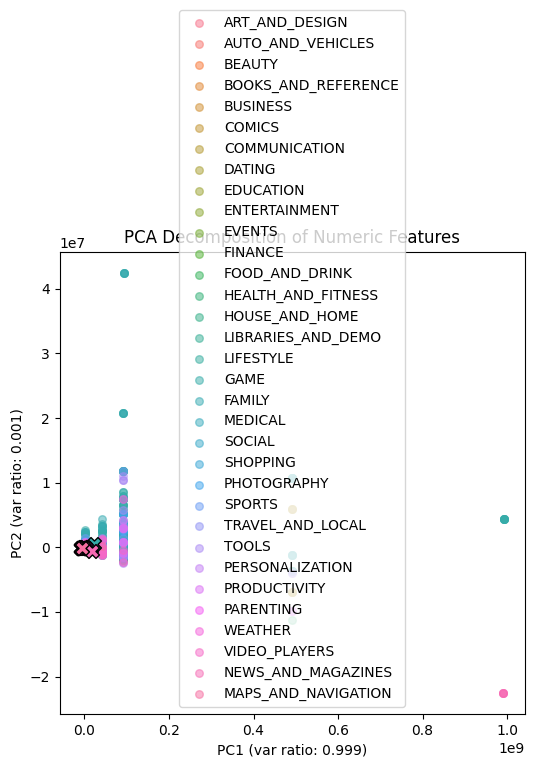

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

category_color_map = {category: color for category, color in zip(pca_df["Category"].unique(), sns.color_palette("husl", len(pca_df["Category"].unique())))}
pc_vr = pca.explained_variance_ratio_.round(3)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel(f"PC1 (var ratio: {pc_vr[0]})")
ax.set_ylabel(f"PC2 (var ratio: {pc_vr[1]})")
ax.set_title("PCA Decomposition of Numeric Features")

centers = pca_df.groupby("Category").agg("mean").reset_index()

for category in pca_df["Category"].unique():
    id = pca_df["Category"] == category
    ax.scatter(
        pca_df.loc[id, "principal component 1"],
        pca_df.loc[id, "principal component 2"],
        c=category_color_map[category],
        s=30,
        alpha=0.5,
        label=category
    )

for category in pca_df["Category"].unique():
    ax.scatter(
        centers.loc[centers["Category"] == category, "principal component 1"],
        centers.loc[centers["Category"] == category, "principal component 2"],
        c=category_color_map[category],
        s=100,
        edgecolors="black",
        marker='X'
    )

ax.legend()
plt.show()

From the plot we can see PC2 has more ratio compares to PC1. PC2 has more clear group of media and news apps, seems rating still take a part when we are seeking the most important components

## PCA (by genres)

In [67]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml import Pipeline
import requests

#since 'genre' has multiple words to define different categories an app can be,
#we are tokennizing the words in 'genre' to analyze it better

tokenize = RegexTokenizer(minTokenLength = 2)\
  .setGaps(False)\
  .setPattern('\\p{L}+')\
  .setInputCol('Genres')\
  .setOutputCol('words')

# remove stop words
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words')\
  .text\
  .split()

remove_sw = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol('words')\
  .setOutputCol('filtered')

# count vectorizer
cv = CountVectorizer(inputCol = 'filtered',
                     outputCol = 'tf')

# compute the inverse document frequency
idf = IDF(inputCol = 'tf',
          outputCol = 'features') #tfidf
pipe_features = Pipeline() \
     .setStages([tokenize,
                 remove_sw,
                 cv,
                 idf])

ds_features = pipe_features\
  .fit(df)\
  .transform(df)\
  #.toPandas()\
  #.head()

ds_features.select('features')\
  .show(5,
        truncate = False)

+--------------------------------------------------------------------------------------+
|features                                                                              |
+--------------------------------------------------------------------------------------+
|(66,[49,50],[4.825341582888492,4.825341582888492])                                    |
|(66,[39,40,49,50],[4.486567849279,4.486567849279,4.825341582888492,4.825341582888492])|
|(66,[49,50],[4.825341582888492,4.825341582888492])                                    |
|(66,[49,50],[4.825341582888492,4.825341582888492])                                    |
|(66,[49,50,62],[4.825341582888492,4.825341582888492,5.486740065133858])               |
+--------------------------------------------------------------------------------------+
only showing top 5 rows



In [68]:
#doing PCA on tokenized 'Genre' col now labelled as 'features'
from pyspark.ml.feature import PCA
pca = PCA(k = 2,
                  inputCol = 'features',
                  outputCol = 'scores')

pipe_pca = Pipeline(stages = [tokenize,
                              remove_sw,
                              cv,
                              idf,
                              pca])
ds_features_1 = pipe_pca\
  .fit(df)\
  .transform(df)

pca_pipe_model = pipe_pca\
  .fit(df)
pca_model = pca_pipe_model.stages[-1]

pc1 = pca_model.pc.toArray()[:, 0].tolist()
pc2 = pca_model.pc.toArray()[:, 1].tolist()

vocabulary = pca_pipe_model.stages[2].vocabulary #vocabulary = Genre

pc_loadings = pd.DataFrame([vocabulary, pc1, pc2])\
  .T\
  .rename(columns = {0: 'genre_word',
                     1: 'load_pc1',
                     2: 'load_pc2'})

app_names = np.array(df\
                        .select('App')\
                        .rdd\
                        .map(lambda x: x['App'])\
                        .collect())

X = np.array(pca_pipe_model.transform(df)\
             .select('scores')\
             .rdd\
             .map(lambda x: x['scores'])\
             .collect())


In [69]:
pc_loadings.T

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
genre_word,tools,education,entertainment,action,medical,personalization,lifestyle,finance,sports,business,...,comics,parenting,card,events,beauty,casino,creativity,trivia,word,audio
load_pc1,-0.030277,-0.044413,0.026153,-0.06972,-0.014863,-0.012658,-0.012814,-0.011916,-0.012663,-0.010985,...,-0.002045,0.012172,-0.002706,-0.001657,-0.001616,-0.001409,0.011794,-0.001201,-0.001076,0.004425
load_pc2,0.032369,0.096104,0.026088,0.140853,0.014582,0.012237,0.012658,0.011462,0.013471,0.010497,...,0.001902,0.0019,0.003639,0.001464,0.001427,0.001241,0.004214,0.001056,0.000945,-0.000176


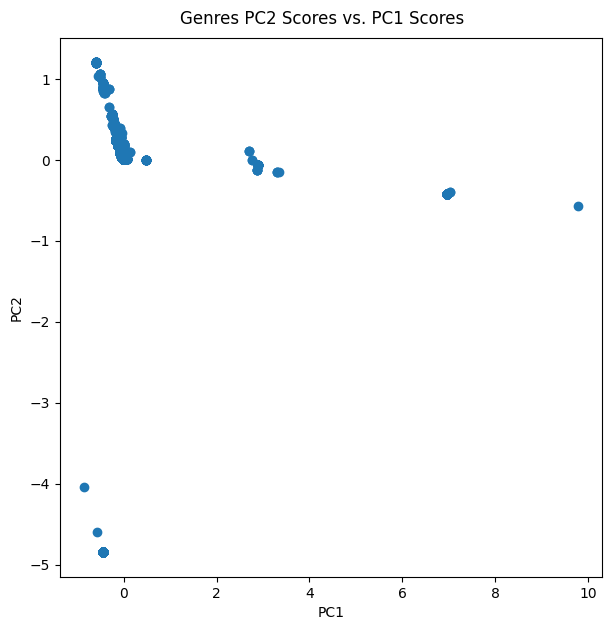

In [70]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X[:, 0], X[:, 1])
fig.suptitle('Genres PC2 Scores vs. PC1 Scores', y=0.92)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# for i, app_name in enumerate(app_names):
#     ax.annotate(app_name, (X[i, 0], X[i, 1]))

plt.show()

The PCA by genres shows the similar result as PCA by categories. The 'genres' of an App affects its weightage in the 2 principle components. This is evident from the position of the 'scores' of genre of each app. PC2 captures more apps with higer 'scores'

# Apriori Genre as the item
Given that we have identified that not all genres have equal importance and contributions to the principal component, we want to explore how the genre affect installation for the apps who have more than 500000 installations.

In [71]:
df = filtered_df = df.filter(df['installs'] > 500000)

From the privious research we can see there are some combination in between Genre and the download volume, thus we subset those installation number more than 500000 as the "high download group" and use Apriori to see the associate rules.

In [72]:
from pyspark.sql.functions import split, explode, collect_list
from mlxtend.frequent_patterns import apriori, association_rules

df_apriori = df.select("App", "Genres",'installs')
df_apriori = df_apriori.dropna()
df_apriori = df_apriori.withColumn("Genres", split("Genres", ";|&")) # Split the Genres column by ";" and "&"
df_apriori = df_apriori.select("App", explode("Genres").alias("Genre"))

df_test = df_apriori.groupBy(df_apriori.App).agg(collect_list('Genre'))
df_test.show()

+--------------------+--------------------+
|                 App| collect_list(Genre)|
+--------------------+--------------------+
|"Eat Fast Prepare...|     [Food ,  Drink]|
|+Download 4 Insta...|            [Social]|
|100 Doors of Revenge|            [Puzzle]|
|104 Looking for a...|          [Business]|
|                11st|          [Shopping]|
|1800 Contacts - L...|  [Medical, Medical]|
|1LINE – One Line ...|             [Board]|
|2ndLine - Second ...|     [Communication]|
|365Scores - Live ...|    [Sports, Sports]|
|3D Blue Glass Wat...|   [Personalization]|
|          3D Bowling|            [Sports]|
|3D DJ – DJ Mixer ...|     [Entertainment]|
|   3D Holograms Joke|        [Simulation]|
|           3D Tennis|            [Sports]|
|          4 in a row|             [Board]|
|      4x4 Jeep Racer|            [Racing]|
|50000 Free eBooks...|[Books ,  Reference]|
|591 housing trans...|     [House ,  Home]|
|7 Nights at Pixel...|         [Adventure]|
|         8 Ball Pool|[Sports, S

Get each genre to a singel value

In [73]:
df_pivot = df_apriori.groupBy("App").pivot("Genre").agg({"Genre": "count"}).na.fill(0)

def transform_row(row):
    app_name = row['App']
    category_indices = [index for index, value in enumerate(row[1:]) if value != 0]
    return (app_name, category_indices)

transformed_data = [transform_row(row) for row in df_pivot.collect()]

new_df = spark.createDataFrame(transformed_data, ["Apps", "Category_Indices"])

new_df.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


+--------------------+----------------+
|                Apps|Category_Indices|
+--------------------+----------------+
|Nigeria News NAIJ...|         [8, 45]|
|    Basketball Stars|            [57]|
|Mercari: The Sell...|            [54]|
|THE KING OF FIGHT...|            [13]|
|Zombie Death Shooter|            [16]|
|         Life market|            [54]|
|Where is my Train...|         [7, 60]|
|         Galaxy Gift|            [40]|
|  Moto Suggestions ™|            [59]|
|      Bounce Classic|            [16]|
|Six Pack Abs Phot...|            [48]|
|     Candy Pop Story|        [22, 26]|
|    Motocross Mayhem|            [52]|
|  Classic Calculator|            [59]|
|           Boomerang|    [12, 33, 44]|
|No.Draw - Colors ...|        [22, 33]|
| Subway Simulator 3D|            [55]|
|WDAMAGE: Car Cras...|            [52]|
|issuu - Read Maga...|         [8, 45]|
|Collage&Add Stick...|            [48]|
+--------------------+----------------+
only showing top 20 rows



In [74]:
from pyspark.ml.fpm import FPGrowth

fpGrowth = FPGrowth(itemsCol="Category_Indices", minSupport=0.0005, minConfidence=0.005)
model = fpGrowth.fit(new_df)

model.freqItemsets.show() # Display frequent itemsets
model.associationRules.show() # Display generated association rules

# transform examines the input items against all the association rules and summarize the
# consequents as prediction
model.transform(new_df).show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


+--------+----+
|   items|freq|
+--------+----+
|    [49]|  38|
|[49, 33]|   2|
|[49, 26]|  17|
|[49, 32]|   8|
|[49, 53]|   3|
|[49, 31]|   4|
|    [11]|  13|
|[11, 18]|  13|
|    [55]|  93|
|    [38]|  20|
| [38, 6]|  20|
|    [19]|   6|
|    [60]|  54|
|    [25]|  12|
|    [36]|  30|
|    [56]|  58|
|    [33]| 129|
|    [37]|  68|
|    [29]|  16|
|[29, 33]|   2|
+--------+----+
only showing top 20 rows

+----------+----------+--------------------+------------------+--------------------+
|antecedent|consequent|          confidence|              lift|             support|
+----------+----------+--------------------+------------------+--------------------+
|      [55]|      [14]| 0.07526881720430108| 3.177874977218881|0.002810116419108...|
|      [55]|       [0]| 0.07526881720430108| 3.177874977218881|0.002810116419108...|
|   [0, 16]|      [14]|                 1.0| 42.22033898305085|0.002810116419108...|
|      [16]|      [14]| 0.06666666666666667|2.8146892655367233|0.002810116419108

In [75]:
from pyspark.sql.functions import desc
sorted_df = model.associationRules.sort(desc("confidence"))#,desc("support"))
sorted_df.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


+----------+----------+----------+------------------+--------------------+
|antecedent|consequent|confidence|              lift|             support|
+----------+----------+----------+------------------+--------------------+
|   [0, 16]|      [14]|       1.0| 42.22033898305085|0.002810116419108...|
|       [0]|      [14]|       1.0| 42.22033898305085|0.023685266961059815|
|  [15, 14]|       [0]|       1.0| 42.22033898305085|0.001204335608189...|
|   [53, 0]|      [14]|       1.0| 42.22033898305085|8.028904054596548E-4|
|  [14, 13]|       [0]|       1.0| 42.22033898305085|0.003211561621838619|
|  [14, 33]|       [0]|       1.0| 42.22033898305085|0.001204335608189...|
|      [36]|       [3]|       1.0| 83.03333333333333| 0.01204335608189482|
|       [6]|      [38]|       1.0|            124.55|0.008028904054596548|
|   [51, 0]|      [14]|       1.0| 42.22033898305085|8.028904054596548E-4|
|      [62]|       [4]|       1.0| 44.48214285714286|0.022480931352870333|
|      [18]|      [11]|  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
